In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import Module, ModuleList, Linear, functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler as sc

In [2]:
batch_size = 8
lr = 1e-3

Load dataset

In [3]:
df = pd.read_csv('data.csv')
df.head()

,ID,CAPSULE,AGE,RACE,DPROS,DCAPS,PSA,VOL,GLEASON
0,1,0,65,1,2,1,1.4,0.0,6
1,2,0,72,1,3,2,6.7,0.0,7
2,3,0,70,1,1,2,4.9,0.0,6
3,4,0,76,2,2,1,51.2,20.0,7
4,5,0,69,1,1,1,12.3,55.9,6


In [4]:
df = df.drop(labels = ['ID'], axis = 1)  # drop column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CAPSULE  380 non-null    int64  
 1   AGE      380 non-null    int64  
 2   RACE     380 non-null    int64  
 3   DPROS    380 non-null    int64  
 4   DCAPS    380 non-null    int64  
 5   PSA      380 non-null    float64
 6   VOL      380 non-null    float64
 7   GLEASON  380 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 23.9 KB


GLEASON hist plot

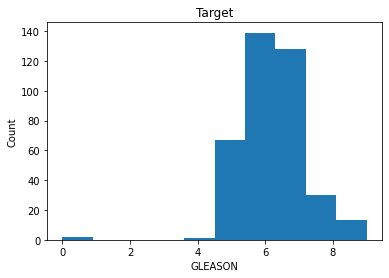

In [5]:
plt.title('Target')
plt.xlabel('GLEASON')
plt.ylabel('Count')
plt.hist(df.GLEASON)
plt.show()

Correlation Plot

    GLEASON과 correlation이 높은 features는 없는 듯

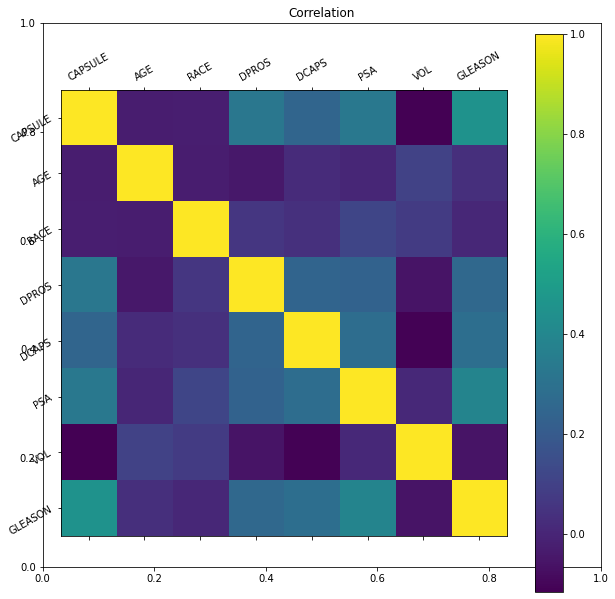

In [6]:
fig = plt.figure(figsize = (10, 10))
plt.title('Correlation')
plt.matshow(df.corr(), fignum = fig.number)
plt.xticks(range(df.shape[1]), df.columns, 
            fontsize=10, rotation=30)
plt.yticks(range(df.shape[1]), df.columns,
            fontsize=10, rotation=30)
color_bar = plt.colorbar()
color_bar.ax.tick_params(labelsize = 10)

Preprocessing

In [7]:
x_normal = df.iloc[df.GLEASON.values != 8, :-1].values
x_abnormal = df.iloc[df.GLEASON.values == 8, :-1].values

In [8]:
scaler = sc()
scaler.fit(x_normal)
x_normal_scaled = scaler.transform(x_normal)
x_abnormal_scaled = scaler.transform(x_abnormal)

In [9]:
x_normal_tensor = torch.tensor(x_normal_scaled, dtype = torch.float)
print(f'Size of normal X : {x_normal_tensor.size()}')
x_normal_tensor = x_normal_tensor.view(-1, 350, 7)
print(f'Size of normal X after view : {x_normal_tensor.size()}')

Size of normal X : torch.Size([350, 7])
Size of normal X after view : torch.Size([1, 350, 7])


In [10]:
loader = DataLoader(x_normal_tensor, batch_size, shuffle = True)

Auto Encoder

In [11]:
class AE(nn.Module):
    def __init__(self, hid_dims = [5,5,5]):
        super(AE, self).__init__()
        self.hid_dims = hid_dims
        
        # Layers        
        self.layers = []
        for t in range(len(self.hid_dims)-1):
            self.layers.append(Linear(self.hid_dims[t],
                                self.hid_dims[t+1]))
                                
        for t in range(1, len(self.hid_dims))[::-1]:
            self.layers.append(Linear(self.hid_dims[t],
                                self.hid_dims[t-1]))
        self.layers = ModuleList(self.layers)
        
    def forward(self, x, drop_rate = None):
        for layer in self.layers:
            x = layer(x)
            x = F.relu(x)
            if drop_rate is None:
                pass
            else:
                x = F.dropout(x, p = drop_rate)
        return x

In [12]:
model = AE(hid_dims = [7, 28, 144])

opt = torch.optim.Adam(model.parameters(), lr = lr)

In [13]:
for epoch in range(1000): 
    loss = 0
    for batch in loader:
        opt.zero_grad()
        for x in batch:
            AE_output = model(x)
            loss += torch.square(AE_output-x)
        loss = torch.sqrt(loss).mean()
        loss.backward()
        opt.step()
    if (epoch+1)%20==0:
        print(f'{epoch+1} epoch - loss : {loss.item()}')    

20 epoch - loss : 0.2601374089717865
40 epoch - loss : 0.2153436839580536
60 epoch - loss : 0.16748686134815216
80 epoch - loss : 0.13175731897354126
100 epoch - loss : 0.12231369316577911
120 epoch - loss : 0.11330783367156982
140 epoch - loss : 0.10509621351957321
160 epoch - loss : 0.09780740737915039
180 epoch - loss : 0.09488707035779953
200 epoch - loss : 0.09266269207000732
220 epoch - loss : 0.09171891212463379
240 epoch - loss : 0.091476209461689
260 epoch - loss : 0.09088800102472305
280 epoch - loss : 0.09068215638399124
300 epoch - loss : 0.08915255963802338
320 epoch - loss : 0.08793649822473526
340 epoch - loss : 0.08893837779760361
360 epoch - loss : 0.08684245496988297
380 epoch - loss : 0.08814074844121933
400 epoch - loss : 0.08752014487981796
420 epoch - loss : 0.08695480972528458
440 epoch - loss : 0.08723998814821243
460 epoch - loss : 0.08626951277256012
480 epoch - loss : 0.08674459904432297
500 epoch - loss : 0.08748924732208252
520 epoch - loss : 0.087266981601

In [14]:
model.eval()

def abnomaly_score(x):    
    x = torch.tensor(x, dtype = torch.float).view(1, -1, 7)
    AE_output = model(x)
    result = torch.square(AE_output-x).sum().item()
    return result

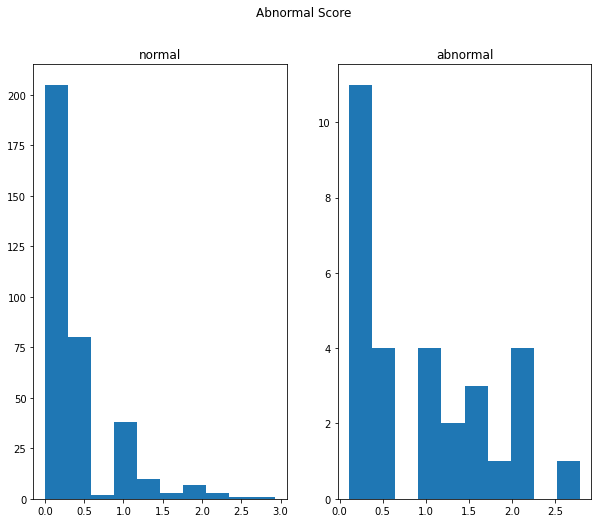

In [15]:
score_normal = [abnomaly_score(x) for x in x_normal_scaled]
score_abnormal = [abnomaly_score(x) for x in x_abnormal_scaled]
fig, ax = plt.subplots(1, 2, figsize = (10, 8))
plt.suptitle('Abnormal Score')
ax[0].set_title('normal')
ax[0].hist(score_normal)
ax[1].set_title('abnormal')
ax[1].hist(score_abnormal)
plt.show()